<a href="https://colab.research.google.com/github/KonstantinSV/image-recognition-tuberculosis/blob/main/%D0%9E%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D1%82%D1%83%D0%B1%D0%B5%D1%80%D0%BA%D1%83%D0%BB%D0%B5%D0%B7%D0%B0_%D0%BF%D0%BE_%D1%84%D0%BB%D1%8E%D0%BE%D1%80%D0%BE%D0%B3%D1%80%D0%B0%D1%84%D0%B8%D0%B8_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Проект: определение туберкулеза по флюорографии**

Цель - обучить нейронную сеть, которая будет классифицировать изображения на норму или паталогию.

Данные для обучения:
- Датасет на Kaggle - https://www.kaggle.com/kmader/pulmonary-chest-xray-abnormalities/home

# Загрузка и просмотр данных

In [ ]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib
import PIL
from skimage.transform import resize
%matplotlib inline

In [ ]:
# Данные предоставлены в двух дирректориях. 
# china_list - для обучения
# montgomery_list - для тестирования
china_list = os.listdir('/content/drive/MyDrive/Colab Notebooks/projects/ChinaSet_AllFiles/CXR_png')
montgomery_list = os.listdir('/content/drive/MyDrive/Colab Notebooks/projects/CXR_png')

Размер изображения из каталога china_list : (1521, 1341)


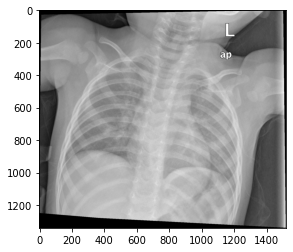

In [ ]:
# Посмотрим первый файл из первой дирректории
os.chdir(r'/content/drive/MyDrive/Colab Notebooks/projects/ChinaSet_AllFiles/CXR_png')
img_ch = PIL.Image.open(china_list[1])
matplotlib.pyplot.imshow(img_ch)
print("Размер изображения из каталога china_list :", img_ch.size)

In [ ]:
img_path = 'base_dir/train_dir/Normal/CHNCXR_0163_0.png'
img = image.load_img(img_path, target_size=(image_size, image_size))
plt.imshow(img)
plt.show()

Размер изображения из каталога montgomery_list : (4892, 4020)


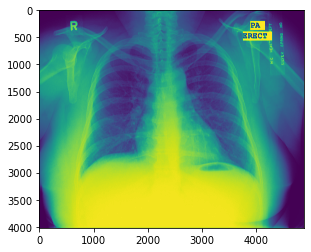

In [ ]:
# Посмотрим первый файл из второй дирректории
os.chdir(r'/content/drive/MyDrive/Colab Notebooks/projects/CXR_png')
img_mo = PIL.Image.open(montgomery_list[1])
matplotlib.pyplot.imshow(img_mo)
print("Размер изображения из каталога montgomery_list :", img_mo.size)

# Предварительная обработка данных

In [ ]:
# Фун-ия для определения метки. Норма - 0, паталогия - 1
def lable_class(x):
    i = int(x[-5])
    if i == 0:
        return 0
    if i == 1:
        return 1

In [ ]:
# Выделим из данных для обучения данные для проверки (25%)
ind_val_train = int(len(china_list) * (1 - 0.75))
val_train = china_list[:ind_val_train]
train = china_list[ind_val_train:]
test = montgomery_list

In [ ]:
# Создадим DataFrame, добавим метки классов.
df_train = pd.DataFrame(train, columns=['image'])
df_val_train = pd.DataFrame(val_train, columns=['image'])
df_test = pd.DataFrame(test, columns=['image'])


df_train['target'] = df_train['image'].apply(lable_class)
df_val_train['target'] = df_val_train['image'].apply(lable_class)
df_test['target'] = df_test['image'].apply(lable_class)

# Сравним соотношение меток класс 0 и класса 1 в обучающей и проверочной выборках.
print(df_train['target'].value_counts())
print(df_val_train['target'].value_counts())
print(df_test['target'].value_counts())

1    302
0    175
Name: target, dtype: int64
0    150
1      8
Name: target, dtype: int64
0    80
1    58
Name: target, dtype: int64


Очевидно что классы неравномерно распределены в обучающей и проверочной выборках. Для более равномерного распределения выборок перемешаем данные в china_list.

In [ ]:
random.shuffle(china_list)

In [ ]:
# Выделим из данных для обучения данные для проверки (25%)
ind_val_train = int(len(china_list) * (1 - 0.75))
val_train = china_list[:ind_val_train]
train = china_list[ind_val_train:]
test = montgomery_list

In [ ]:
# Создадим DataFrame, добавим метки классов.
df_train = pd.DataFrame(train, columns=['image'])
df_val_train = pd.DataFrame(val_train, columns=['image'])
df_test = pd.DataFrame(test, columns=['image'])


df_train['target'] = df_train['image'].apply(lable_class)
df_val_train['target'] = df_val_train['image'].apply(lable_class)
df_test['target'] = df_test['image'].apply(lable_class)

# Сравним соотношение меток класс 0 и класса 1 в обучающей и проверочной выборках.
print(df_train['target'].value_counts())
print(df_val_train['target'].value_counts())
print(df_test['target'].value_counts())

0    247
1    230
Name: target, dtype: int64
1    80
0    78
Name: target, dtype: int64
0    80
1    58
Name: target, dtype: int64


Для использования сети Google InceptionV3 изображения необходимо преобразовать к размеру 299х299

In [ ]:
# Загружаем все изображения из первой дирректории, преобразуем их в массив numpy и меняем размер.
conv_train =[]
for image_file_name in train:
  path = os.path.join(r'/content/drive/MyDrive/Colab Notebooks/projects/ChinaSet_AllFiles/CXR_png', image_file_name)
  image = PIL.Image.open(path)
  (im_width, im_height) = image.size
  image_np = np.array(image.getdata()).reshape((im_height, im_width)).astype(np.uint8)
  image_np = resize(image_np, (299, 299), anti_aliasing=True)
  conv_train.append(image_np)

In [ ]:
conv_val_train =[]
for image_file_name in val_train:
  path = os.path.join(r'/content/drive/MyDrive/Colab Notebooks/projects/ChinaSet_AllFiles/CXR_png', image_file_name)
  image = PIL.Image.open(path)
  (im_width, im_height) = image.size
  image_np = np.array(image.getdata()).reshape((im_height, im_width)).astype(np.uint8)
  image_np = resize(image_np, (299, 299), anti_aliasing=True)
  conv_val_train.append(image_np)

In [ ]:
# Загружаем все изображения из второй дирректории, преобразуем их в массив numpy и меняем размер.
conv_test = []
for image_file_name in test:
  path = os.path.join(r'/content/drive/MyDrive/Colab Notebooks/projects/CXR_png', image_file_name)
  image = PIL.Image.open(path)
  (im_width, im_height) = image.size
  image_np = np.array(image.getdata()).reshape((im_height, im_width)).astype(np.uint8)
  image_np = resize(image_np, (299, 299), anti_aliasing=True)
  conv_test.append(image_np)

In [ ]:
print("Размер преобразованного изображения из обучающей выборки:", conv_train[1].shape)
print("Размер преобразованного изображения из проверочной выборки:", conv_val_train[1].shape)
print("Размер преобразованного изображения из тестовой выборки:", conv_test[1].shape)

Размер преобразованного изображения из обучающей выборки: (299, 299)
Размер преобразованного изображения из проверочной выборки: (299, 299)
Размер преобразованного изображения из тестовой выборки: (299, 299)


Cоздание директории с двумя вложенными директориями и копируем в них изображения с разными метками классов

In [ ]:
# Фун-ия создания директории с двумя вложенными директориями (по кол-ву меток классов).
def directory(path_name_dir):
    if os.path.exists(path_name_dir):
        shutil.rmtree(path_name_dir)
    os.makedirs(path_name_dir)
    os.makedirs(os.path.join(path_name_dir, "Normal"))
    os.makedirs(os.path.join(path_name_dir, "Tuberculosis"))

In [ ]:
directory("/content/drive/MyDrive/Colab Notebooks/projects/base_dir/train_dir")
directory("/content/drive/MyDrive/Colab Notebooks/projects/base_dir/val_dir")
directory("/content/drive/MyDrive/Colab Notebooks/projects/base_dir/test_dir")

В соответствии с требованиями Keras изображения распределены в директории по классам.

In [ ]:
# Фун-ия определяет метку класса и  копирует изображения с разными метками в отдельные директории в соответствии с требованиями Keras 
def copy_images(data_base, conv_data_base, path_normal, path_Tuberculosis):
  for index, i in enumerate(data_base):
    lable = int(i[-5])
    if lable == 0:
      matplotlib.image.imsave(path_normal + str(i) + '.png', conv_data_base[index-1])
    if lable == 1:
      matplotlib.image.imsave(path_Tuberculosis + str(i) + '.png', conv_data_base[index-1])

In [ ]:
# Сохраним в переменных пути директорий для изображений для обучения, проверки и тестирования 
path_train_normal = '/content/drive/MyDrive/Colab Notebooks/projects/base_dir/train_dir/Normal/'
path_train_Tuberculosis = '/content/drive/MyDrive/Colab Notebooks/projects/base_dir/train_dir/Tuberculosis/'


path_val_train_normal = '/content/drive/MyDrive/Colab Notebooks/projects/base_dir/val_dir/Normal/'
path_val_train_Tuberculosis = '/content/drive/MyDrive/Colab Notebooks/projects/base_dir/val_dir/Tuberculosis/'


path_test_normal = '/content/drive/MyDrive/Colab Notebooks/projects/base_dir/test_dir/Normal/'
path_test_Tuberculosis = '/content/drive/MyDrive/Colab Notebooks/projects/base_dir/test_dir/Tuberculosis/'

In [ ]:
# Изображения из дирректории train копируем в папку для обучения 
copy_images(train, conv_train, path_train_normal, path_train_Tuberculosis)

# Изображения из дирректории val_train копируем в папку для проверки
copy_images(val_train, conv_val_train, path_val_train_normal, path_val_train_Tuberculosis)

# Изображения из дирректории conv_mont копируем в папку для тестирования
copy_images(test, conv_test, path_test_normal, path_test_Tuberculosis)

# Генераторы изображений

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Для более качественного обучения сети необходимо как можно бошльше данных. С этой целью создадим генераторы изображений

In [ ]:
# Для удобства сохраним размер изображения в переменной
image_size = 299

# Размер мини-выборки
batch_size = 32

# Размерность тензора на основе изображения для входных данных в нейронную сеть
input_shape = (image_size, image_size, 3)

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/projects/base_dir/train_dir'
val_dir = '/content/drive/MyDrive/Colab Notebooks/projects/base_dir/val_dir'
test_dir = '/content/drive/MyDrive/Colab Notebooks/projects/base_dir/test_dir'

Генератор с дополнением данных

In [ ]:
# rescale - Нормализация изображений 
# rotation_range - поворот изображений
# width_shift_range, height_shift_range - сдвиг по ширине и высоте
# zoom_range- изменение размера

train_datagen = ImageDataGenerator(rescale=1. / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest')

Проверка работы генератора

In [ ]:
# image.img_to_array() - преобразует изображение в массив numpy. Необходимо для преобразования размерности
# reshape((1,) + x.shape) - для работы генератора нужна размерность 4.

img_path = '/content/drive/MyDrive/Colab Notebooks/projects/base_dir/train_dir/Normal/CHNCXR_0001_0.png.png'
img = image.load_img(img_path)
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    matplotlib.pyplot.figure(i)
    imgplot = matplotlib.pyplot.imshow(image.array_to_img(batch[0]))
    i += 1
    if i == 6:
        break
matplotlib.pyplot.show()

Генератор изображений для обучения для задачи бинарной классификации (class_mode='binary') 

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary')

Found 477 images belonging to 2 classes.


Генератор изображений для проверки 

In [ ]:
val_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary')

Found 158 images belonging to 2 classes.


Генератор для тестирования

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary')

Found 138 images belonging to 2 classes.


In [ ]:
# Номера классов в генераторах
print(train_generator.class_indices)
print(val_generator.class_indices)
print(test_generator.class_indices)

{'Normal': 0, 'Tuberculosis': 1}
{'Normal': 0, 'Tuberculosis': 1}
{'Normal': 0, 'Tuberculosis': 1}


# Загрузка предварительно обученной нейросети из Keras 

In [ ]:
pretrained_model = InceptionV3(weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


"Замораживаем" веса предварительно обученной нейронной сети

In [ ]:
pretrained_model.trainable = False

Создаем составную нейронную сеть

In [ ]:
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)

# Обучаем составную нейронную сеть на основе InceptionV3

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4), 
              metrics=['accuracy'])

In [ ]:
# checkpoint - в процессе обучения сохраняем лучшие веса модели, если val_accuracy больше чем на предыдущих этапах
# learning_rate_reduction - снижаем скорость обучения если в течении 3 эпох val_accuracy нне снижается
filepath="/content/drive/MyDrive/Colab Notebooks/projects/inceptionv3_tuberculosis.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks_list = [checkpoint, learning_rate_reduction]

In [ ]:
history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    validation_freq=1,
    epochs=20,
    verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20

Epoch 00001: val_accuracy improved from -inf to 0.46835, saving model to /content/drive/MyDrive/Colab Notebooks/projects/inceptionv3_tuberculosis.h5
15/15 - 301s - loss: 0.8453 - accuracy: 0.5010 - val_loss: 0.7104 - val_accuracy: 0.4684
Epoch 2/20

Epoch 00002: val_accuracy did not improve from 0.46835
15/15 - 130s - loss: 0.7839 - accuracy: 0.5451 - val_loss: 0.7152 - val_accuracy: 0.4367
Epoch 3/20

Epoch 00003: val_accuracy did not improve from 0.46835
15/15 - 130s - loss: 0.7756 - accuracy: 0.5241 - val_loss: 0.7231 - val_accuracy: 0.4620
Epoch 4/20

Epoch 00004: val_accuracy did not improve from 0.46835

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
15/15 - 130s - loss: 0.7917 - accuracy: 0.5514 - val_loss: 0.7120 - val_accuracy: 0.4684
Epoch 5/20

Epoch 00005: val_accuracy improved from 0.46835 to 0.48101, saving model to /content/drive/MyDrive/Colab Notebook

# Дообучение сверточных слоев модели 

Загрузка лучших весов полученных в процессе обучения

In [ ]:
model.load_weights("/content/drive/MyDrive/Colab Notebooks/projects/inceptionv3_tuberculosis.h5")

Размораживаем два последних блока Inception

In [ ]:
pretrained_model.trainable = False
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

Компилируем и обучаем нейронную сеть с размороженными слоями

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4), 
              metrics=['accuracy'])

In [ ]:
# checkpoint - сохраняем лучшие веса дообученной модели
filepath="/content/drive/MyDrive/Colab Notebooks/projects/inceptionv3_tuberculosis_tuned.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, learning_rate_reduction]

In [ ]:
history = model.fit_generator(
    train_generator,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=5,
    verbose=2)

Epoch 1/5

Epoch 00001: val_accuracy improved from -inf to 0.57971, saving model to /content/drive/MyDrive/Colab Notebooks/projects/inceptionv3_tuberculosis_tuned.h5
15/15 - 274s - loss: 0.8970 - accuracy: 0.5304 - val_loss: 0.8526 - val_accuracy: 0.5797
Epoch 2/5

Epoch 00002: val_accuracy did not improve from 0.57971
15/15 - 156s - loss: 0.7737 - accuracy: 0.5744 - val_loss: 0.6751 - val_accuracy: 0.5652
Epoch 3/5

Epoch 00003: val_accuracy did not improve from 0.57971
15/15 - 156s - loss: 0.6881 - accuracy: 0.6331 - val_loss: 0.6805 - val_accuracy: 0.5580
Epoch 4/5

Epoch 00004: val_accuracy improved from 0.57971 to 0.59420, saving model to /content/drive/MyDrive/Colab Notebooks/projects/inceptionv3_tuberculosis_tuned.h5
15/15 - 162s - loss: 0.6878 - accuracy: 0.6646 - val_loss: 0.6705 - val_accuracy: 0.5942
Epoch 5/5

Epoch 00005: val_accuracy did not improve from 0.59420
15/15 - 158s - loss: 0.6364 - accuracy: 0.6478 - val_loss: 0.7175 - val_accuracy: 0.5507


# Тестирование модели

Загрузка лучших весов полученных в процессе дообучения

In [ ]:
model = load_model("/content/drive/MyDrive/Colab Notebooks/projects/inceptionv3_tuberculosis_tuned.h5")

Оцениваем работу модели на тестовой выборке

In [ ]:
predict = model.evaluate_generator(test_generator)

In [ ]:
print(f'loss:{predict[0]}', f'accuracy:{predict[1]}', sep = '\n')

loss:0.6704518795013428
accuracy:0.5942028760910034


Вывод: С учетом мизирного кол-ва данных для обучения, модель показала относительно хорошие результаты. 